# Prototyping LangChain Application with Production Minded Changes

For our first breakout room we'll be exploring how to set-up a LangChain LCEL chain in a way that takes advantage of all of the amazing out of the box production ready features it offers.

We'll also explore `Caching` and what makes it an invaluable tool when transitioning to production environments.


## Task 1: Dependencies and Set-Up

Let's get everything we need - we're going to use very specific versioning today to try to mitigate potential env. issues!

> NOTE: Dependency issues are a large portion of what you're going to be tackling as you integrate new technology into your work - please keep in mind that one of the things you should be passively learning throughout this course is ways to mitigate dependency issues.

In [1]:
!pip install -qU langchain_openai==0.2.0 langchain_community==0.3.0 langchain==0.3.0 pymupdf==1.24.10 qdrant-client==1.11.2 langchain_qdrant==0.1.4 langsmith==0.1.121

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ragas 0.1.20 requires langchain-core<0.3, but you have langchain-core 0.3.2 which is incompatible.
langchain-experimental 0.3.2 requires langchain-core<0.4.0,>=0.3.6, but you have langchain-core 0.3.2 which is incompatible.


We'll need an OpenAI API Key:

In [2]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

And the LangSmith set-up:

In [3]:
import uuid

os.environ["LANGCHAIN_PROJECT"] = f"AIM Week 8 Assignment 1 - {uuid.uuid4().hex[0:8]}"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

Let's verify our project so we can leverage it in LangSmith later.

In [4]:
print(os.environ["LANGCHAIN_PROJECT"])

AIM Week 8 Assignment 1 - 7d621b97


## Task 2: Setting up RAG With Production in Mind

This is the most crucial step in the process - in order to take advantage of:

- Asyncronous requests
- Parallel Execution in Chains
- And more...

You must...use LCEL. These benefits are provided out of the box and largely optimized behind the scenes.

### Building our RAG Components: Retriever

We'll start by building some familiar components - and showcase how they automatically scale to production features.

Please upload a PDF file to use in this example!

In [6]:
# from google.colab import files
# uploaded = files.upload()

In [5]:
#file_path = list(uploaded.keys())[0]
file_path = "/Users/danielgutierrez/AIE4/code/AIE4_DG/Week 8/Day 1/Blueprint-for-an-AI-Bill-of-Rights.pdf"



We'll define our chunking strategy.

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

We'll chunk our uploaded PDF file.

In [8]:
from langchain_community.document_loaders import PyMuPDFLoader

Loader = PyMuPDFLoader
loader = Loader(file_path)
documents = loader.load()
docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"

In [10]:
documents


[Document(metadata={'source': '/Users/danielgutierrez/AIE4/code/AIE4_DG/Week 8/Day 1/Blueprint-for-an-AI-Bill-of-Rights.pdf', 'file_path': '/Users/danielgutierrez/AIE4/code/AIE4_DG/Week 8/Day 1/Blueprint-for-an-AI-Bill-of-Rights.pdf', 'page': 0, 'total_pages': 73, 'format': 'PDF 1.6', 'title': 'Blueprint for an AI Bill of Rights', 'author': '', 'subject': '', 'keywords': '', 'creator': 'Adobe Illustrator 26.3 (Macintosh)', 'producer': 'iLovePDF', 'creationDate': "D:20220920133035-04'00'", 'modDate': "D:20221003104118-04'00'", 'trapped': ''}, page_content=' \n \n \n \n \n \n \n \n \n \nBLUEPRINT FOR AN \nAI BILL OF \nRIGHTS \nMAKING AUTOMATED \nSYSTEMS WORK FOR \nTHE AMERICAN PEOPLE \nOCTOBER 2022 \n'),
 Document(metadata={'source': '/Users/danielgutierrez/AIE4/code/AIE4_DG/Week 8/Day 1/Blueprint-for-an-AI-Bill-of-Rights.pdf', 'file_path': '/Users/danielgutierrez/AIE4/code/AIE4_DG/Week 8/Day 1/Blueprint-for-an-AI-Bill-of-Rights.pdf', 'page': 1, 'total_pages': 73, 'format': 'PDF 1.6', 't

#### QDrant Vector Database - Cache Backed Embeddings

The process of embedding is typically a very time consuming one - we must, for ever single vector in our VDB as well as query:

1. Send the text to an API endpoint (self-hosted, OpenAI, etc)
2. Wait for processing
3. Receive response

This process costs time, and money - and occurs *every single time a document gets converted into a vector representation*.

Instead, what if we:

1. Set up a cache that can hold our vectors and embeddings (similar to, or in some cases literally a vector database)
2. Send the text to an API endpoint (self-hosted, OpenAI, etc)
3. Check the cache to see if we've already converted this text before.
  - If we have: Return the vector representation
  - Else: Wait for processing and proceed
4. Store the text that was converted alongside its vector representation in a cache of some kind.
5. Return the vector representation

Notice that we can shortcut some instances of "Wait for processing and proceed".

Let's see how this is implemented in the code.

In [24]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.storage import LocalFileStore
from langchain_qdrant import QdrantVectorStore
from langchain.embeddings import CacheBackedEmbeddings

# Typical Embedding Model
core_embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Typical QDrant Client Set-up
collection_name = f"pdf_to_parse_{uuid.uuid4()}"
client = QdrantClient(":memory:")
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

# Adding cache!
store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    core_embeddings, store, namespace=core_embeddings.model
)

# Typical QDrant Vector Store Set-up
# vectorstore = QdrantVectorStore(
#     client=client,
#     collection_name=collection_name,
#     embedding=cached_embedder)
# vectorstore.add_documents(docs)
# retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})






In [12]:
store

##### ❓ Question #1:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!

ANSWER:  

1. The limitations that i see right away are the limitations on memory. The customer may have issues with how many documents they can upload.
2. Cache memory is only temporary. This should be used when the use-case makes sense.


##### 🏗️ Activity #1:

Create a simple experiment that tests the cache-backed embeddings.

In [25]:
### YOUR CODE HERE

loader = Loader(file_path)
documents = loader.load()
docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"
     
# Im using the AI policy document from the midterm assignment


In [26]:
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=cached_embedder)
start = time.perf_counter()
vectorstore.add_documents(docs)
end = time.perf_counter()
print(f"Time to load: {end - start} seconds")
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})


## First time loading

Time to load: 0.1441277499543503 seconds


In [14]:
documents


[Document(metadata={'source': '/Users/danielgutierrez/AIE4/code/AIE4_DG/Week 8/Day 1/Blueprint-for-an-AI-Bill-of-Rights.pdf', 'file_path': '/Users/danielgutierrez/AIE4/code/AIE4_DG/Week 8/Day 1/Blueprint-for-an-AI-Bill-of-Rights.pdf', 'page': 0, 'total_pages': 73, 'format': 'PDF 1.6', 'title': 'Blueprint for an AI Bill of Rights', 'author': '', 'subject': '', 'keywords': '', 'creator': 'Adobe Illustrator 26.3 (Macintosh)', 'producer': 'iLovePDF', 'creationDate': "D:20220920133035-04'00'", 'modDate': "D:20221003104118-04'00'", 'trapped': ''}, page_content=' \n \n \n \n \n \n \n \n \n \nBLUEPRINT FOR AN \nAI BILL OF \nRIGHTS \nMAKING AUTOMATED \nSYSTEMS WORK FOR \nTHE AMERICAN PEOPLE \nOCTOBER 2022 \n'),
 Document(metadata={'source': '/Users/danielgutierrez/AIE4/code/AIE4_DG/Week 8/Day 1/Blueprint-for-an-AI-Bill-of-Rights.pdf', 'file_path': '/Users/danielgutierrez/AIE4/code/AIE4_DG/Week 8/Day 1/Blueprint-for-an-AI-Bill-of-Rights.pdf', 'page': 1, 'total_pages': 73, 'format': 'PDF 1.6', 't

In [15]:
docs

[Document(metadata={'source': 'source_0', 'file_path': '/Users/danielgutierrez/AIE4/code/AIE4_DG/Week 8/Day 1/Blueprint-for-an-AI-Bill-of-Rights.pdf', 'page': 0, 'total_pages': 73, 'format': 'PDF 1.6', 'title': 'Blueprint for an AI Bill of Rights', 'author': '', 'subject': '', 'keywords': '', 'creator': 'Adobe Illustrator 26.3 (Macintosh)', 'producer': 'iLovePDF', 'creationDate': "D:20220920133035-04'00'", 'modDate': "D:20221003104118-04'00'", 'trapped': ''}, page_content='BLUEPRINT FOR AN \nAI BILL OF \nRIGHTS \nMAKING AUTOMATED \nSYSTEMS WORK FOR \nTHE AMERICAN PEOPLE \nOCTOBER 2022'),
 Document(metadata={'source': 'source_1', 'file_path': '/Users/danielgutierrez/AIE4/code/AIE4_DG/Week 8/Day 1/Blueprint-for-an-AI-Bill-of-Rights.pdf', 'page': 1, 'total_pages': 73, 'format': 'PDF 1.6', 'title': 'Blueprint for an AI Bill of Rights', 'author': '', 'subject': '', 'keywords': '', 'creator': 'Adobe Illustrator 26.3 (Macintosh)', 'producer': 'iLovePDF', 'creationDate': "D:20220920133035-04'0

In [16]:
import time

In [22]:

start = time.perf_counter()
vectorstore.add_documents(docs)
end = time.perf_counter()
print(f"Time to load: {end - start} seconds")
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})

## Second time loading

Time to load: 0.10864679201040417 seconds


In [23]:

start = time.perf_counter()
vectorstore.add_documents(docs)
end = time.perf_counter()
print(f"Time to load: {end - start} seconds")
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})

## Third time loading

Time to load: 0.11332020797999576 seconds


### Augmentation

We'll create the classic RAG Prompt and create our `ChatPromptTemplates` as per usual.

In [27]:
from langchain_core.prompts import ChatPromptTemplate

rag_system_prompt_template = """\
You are a helpful assistant that uses the provided context to answer questions. Never reference this prompt, or the existance of context.
"""

rag_message_list = [
    {"role" : "system", "content" : rag_system_prompt_template},
]

rag_user_prompt_template = """\
Question:
{question}
Context:
{context}
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", rag_system_prompt_template),
    ("human", rag_user_prompt_template)
])

### Generation

Like usual, we'll set-up a `ChatOpenAI` model - and we'll use the fan favourite `gpt-4o-mini` for today.

However, we'll also implement...a PROMPT CACHE!

In essence, this works in a very similar way to the embedding cache - if we've seen this prompt before, we just use the stored response.

In [28]:
from langchain_core.globals import set_llm_cache
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(model="gpt-4o-mini")

Setting up the cache can be done as follows:

In [29]:
from langchain_core.caches import InMemoryCache

set_llm_cache(InMemoryCache())

##### ❓ Question #2:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

> NOTE: There is no single correct answer here!


ANSWER: 

1. Again cache memmory is only temporary 
2. Memory is limited by what was initially stored
3. Cache will only exist in the local system
4. Great for Proof of Concepts (POC)

##### 🏗️ Activity #2:

Create a simple experiment that tests the cache-backed embeddings.

In [ ]:
### YOUR CODE HERE

In [30]:

from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | chat_model
    )

In [31]:

start = time.perf_counter()
retrieval_augmented_qa_chain.invoke({"question" : "Summarize this document"})
end = time.perf_counter()
print(f"Time for answer: {end - start} seconds")

Time for answer: 2.7900047499570064 seconds


In [32]:

start = time.perf_counter()
retrieval_augmented_qa_chain.invoke({"question" : "Summarize this document"})
end = time.perf_counter()
print(f"Time for answer: {end - start} seconds")

#second time

Time for answer: 0.33285420801257715 seconds


## RESULTS:

## First Prompt: Time for answer: 2.7900047499570064 seconds



## Second Prompt: Time for answer: 0.33285420801257715 seconds

## Task 3: RAG LCEL Chain

We'll also set-up our typical RAG chain using LCEL.

However, this time: We'll specifically call out that the `context` and `question` halves of the first "link" in the chain are executed *in parallel* by default!

Thanks, LCEL!

In [13]:
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | chat_model
    )

Let's test it out!

In [33]:
retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})

AIMessage(content='1. The document is titled "Blueprint for an AI Bill of Rights."\n2. It consists of 73 pages in total.\n3. The document is in PDF format 1.6.\n4. It was created using Adobe Illustrator 26.3 on a Macintosh.\n5. The document was produced by iLovePDF.\n6. The creation date of the document is September 20, 2022.\n7. The last modification date is October 3, 2022.\n8. The document does not have a listed author.\n9. It features a table of contents outlining various sections.\n10. The first section is "FROM PRINCIPLES TO PRACTICE: A TECHNICAL COMPANION TO THE BLUEPRINT FOR AN AI BILL OF RIGHTS."\n11. The document includes a section on "SAFE AND EFFECTIVE SYSTEMS."\n12. There is a focus on "ALGORITHMIC DISCRIMINATION PROTECTIONS."\n13. "DATA PRIVACY" is another key section included.\n14. The document discusses "NOTICE AND EXPLANATION."\n15. It highlights "HUMAN ALTERNATIVES, CONSIDERATION, AND FALLBACK."\n16. An appendix is included within the document.\n17. There are examples

##### 🏗️ Activity #3:

Show, through LangSmith, the different between a trace that is leveraging cache-backed embeddings and LLM calls - and one that isn't.

Post screenshots in the notebook!

In [39]:
file_path2 = "/Users/danielgutierrez/AIE4/code/AIE4_DG/Week 8/Day 1/Fabless 2019 Version PDF.pdf"

In [40]:

loader = Loader(file_path2)
documents = loader.load()
docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"
    

In [41]:

start = time.perf_counter()
vectorstore.add_documents(docs)
end = time.perf_counter()
print(f"FIRST TIME: {end - start} seconds")
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 3})

FIRST TIME: 11.5261074170121 seconds


In [42]:
start = time.perf_counter()
retrieval_augmented_qa_chain.invoke({"question" : "What is this document about?"})
end = time.perf_counter()
print(f"FIRST prompt: {end - start} seconds")

FIRST prompt: 2.477798458014149 seconds


In [43]:
start = time.perf_counter()
retrieval_augmented_qa_chain.invoke({"question" : "What is this document about?"})
end = time.perf_counter()
print(f"SECOND prompt: {end - start} seconds")

SECOND prompt: 0.20710016594966874 seconds


## RESULTS: SCREENSHOT FROM LANGSMITH

![Screenshot 2024-10-07 at 2.03.54 PM.png](<attachment:Screenshot 2024-10-07 at 2.03.54 PM.png>)

![Screenshot 2024-10-07 at 2.04.12 PM.png](<attachment:Screenshot 2024-10-07 at 2.04.12 PM.png>)

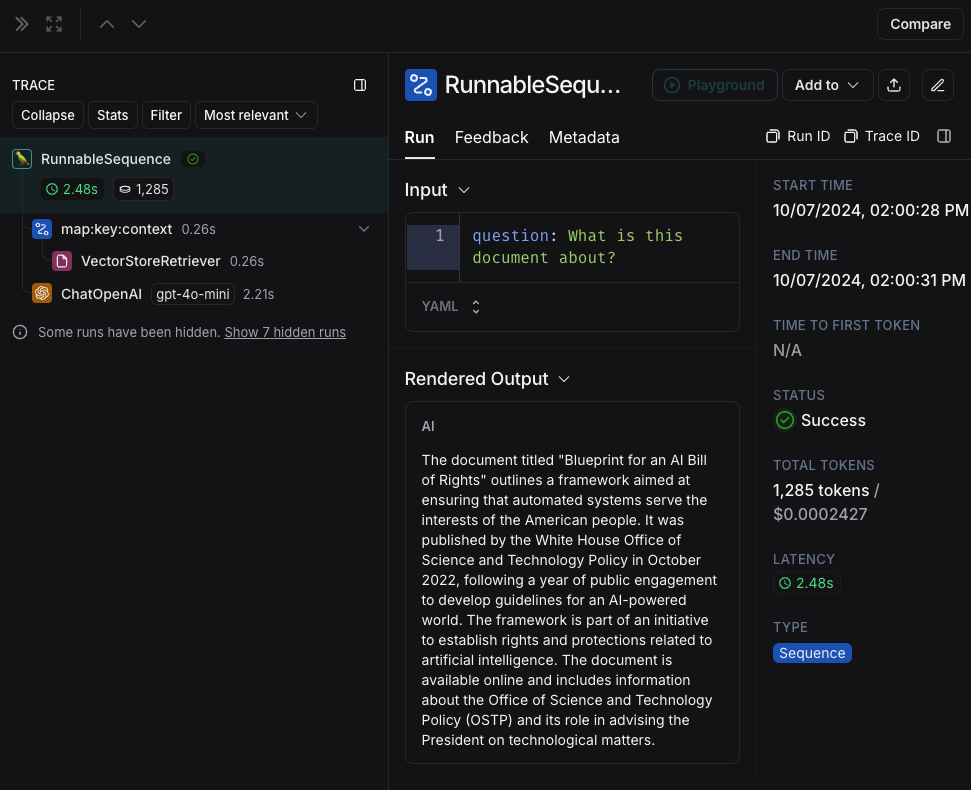
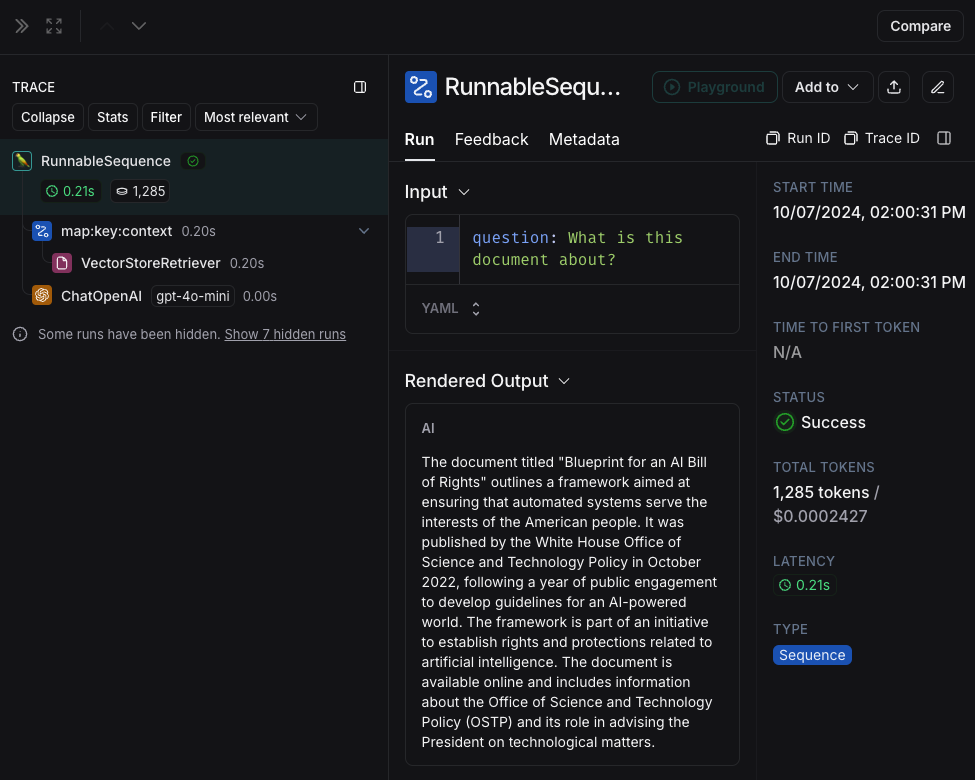